In [1]:
import pandas as pd
import numpy as np
from openff.toolkit.topology import Molecule
from openff.units import unit
import seaborn as sb
from scipy import stats
import matplotlib.pyplot as plt

def equalityline(x, y, ax = None, **kwargs):
    x0, x1 = min(x), max(x)
    y0, y1 = min(y), max(y)
    lims = [min(x0, y0), max(x1, y1)]
    ax = ax or plt.gca()
    ax.plot(lims, lims, **kwargs)

def m(x, y, ax = None, **kwargs):
    x = np.array(x)
    y = np.array(y)
    ax = ax or plt.gca()
    m =(np.sum((x - y)**2, axis=0)/(y.shape[0]))**0.5
    ax.annotate(f'$RMSE= {float(m):.2f}$',
                xy=(.01, .99), xycoords=ax.transAxes, fontsize=8,
                color='darkred', backgroundcolor='#FFFFFF99', ha='left', va='top')   
    
def kde(x, y, ax = None, **kwargs):
    x = np.array(x)
    y = np.array(y)
    ax = ax or plt.gca()
    kernel = stats.gaussian_kde(x)(y)
    ax.scatter(x, y, c=kernel, s=5)

In [2]:
df = pd.read_parquet('/mnt/storage/nobackup/nca121/paper_charge_comparisons/async_chargecraft_more_workers/charge_models.parquet')
df

ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

In [21]:
len(df.iloc[0]['mbis_charges'])

17

In [15]:
def explode_charges(df, charge_columns, molecule_column='molecule'):
    rows = []
    for _, row in df.iterrows():
        charges_dict = {col: row[col] for col in charge_columns if row[col] is not None}
        n_charges = len(charges_dict[charge_columns[0]])  # Number of charges per molecule
        for i in range(n_charges):
            exploded_row = {col: charges_dict[col][i] for col in charge_columns}
            exploded_row[molecule_column] = row[molecule_column]
            exploded_row['element_index'] = i + 1  # Add index for the atom/element
            rows.append(exploded_row)
    return pd.DataFrame(rows)

# Define charge columns
charge_columns = ['mbis_charges', 'am1bcc_charges','riniker_monopoles', 'espaloma_charges','resp_charges']

# Explode the DataFrame
exploded_df = explode_charges(df, charge_columns)


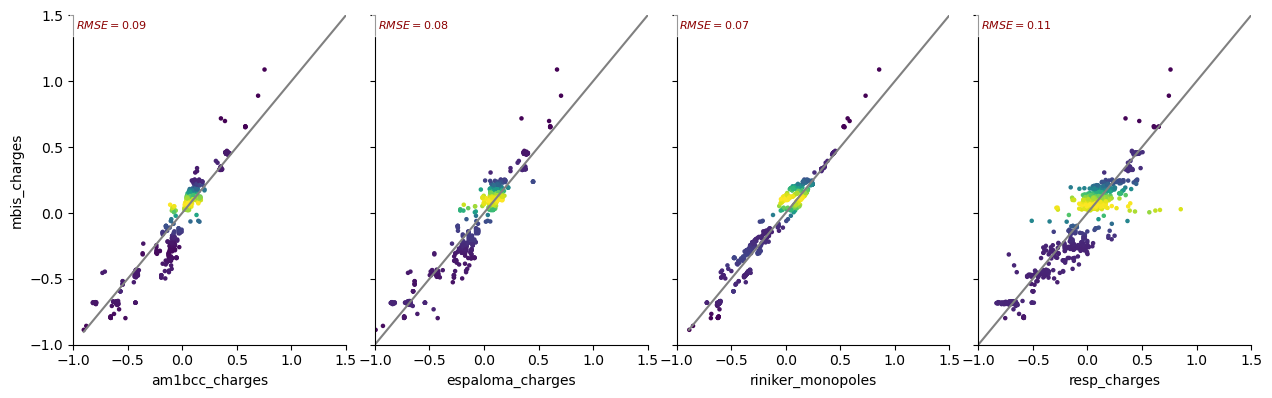

In [16]:
# Define the columns you want to compare against QM_HF_Dipoles
compare_columns = ['am1bcc_charges','espaloma_charges','riniker_monopoles','resp_charges']


# Initialize a PairGrid with col_wrap set to 3 for 3 columns per row
grid = sb.PairGrid(exploded_df, x_vars=compare_columns, y_vars=['mbis_charges'], height=4, aspect=0.8)

# Map the plots to the grid
grid = grid.map(kde)
grid = grid.map_offdiag(equalityline, color='gray', ls='-')
grid = grid.map_offdiag(m)
grid.map_diag(sb.kdeplot, color='gray')

# Set axis limits
grid.set(xlim=(-1,1.5), ylim=(-1,1.5))

# Display the plot
plt.savefig('comparison_of_charges.png', dpi=1000)
plt.show()

In [23]:
len(df.iloc[0]['resp_charges'])

17

In [35]:
df.to_csv('./sanity_check.csv')

In [4]:
df.iloc[0]

mbis_charges                [-0.44171691769759425, 0.19215883543444148, -0...
am1bcc_charges              [-0.15928235294117646, 0.13051764705882352, -0...
espaloma_charges            [-0.2646322256940253, 0.09048017793718506, -0....
riniker_monopole_charges                                                 None
resp_charges                [-0.2238, 0.1144, -0.3794, 0.1839, 0.4749, -0....
qm_dipoles                                                           0.372726
mbis_dipoles                                                         0.196034
am1bcc_dipole                                                        0.099876
espaloma_dipole                                                      0.568253
riniker_dipoles                                                      0.042476
resp_dipole                                                          0.179598
molecule                    [H][O][C]([H])([H])[C]1([H])[O][C]([H])([H])[C...
grid                        [[-4.959543008824821, -1.43442623955

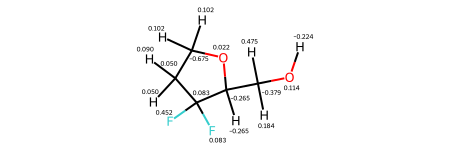

In [20]:
openff_molecule = Molecule.from_smiles(df.iloc[0]['molecule'], allow_undefined_stereo=True)
rdkit_mol = openff_molecule.to_rdkit()
resp_charges =  df.iloc[0]['resp_charges']
for i, atom in enumerate(rdkit_mol.GetAtoms()):
    lbl = '%.3f' % (resp_charges[i])
    atom.SetProp('atomNote', lbl)
rdkit_mol

In [5]:
from chargecraft.storage.storage import MoleculePropRecord, MoleculePropStore
from MultipoleNet import load_model, build_graph_batched, D_Q
riniker_model = load_model()


2024-11-15 15:46:38.691821: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [6]:
prop_store = MoleculePropStore('/mnt/storage/nobackup/nca121/paper_charge_comparisons/async_chargecraft_more_workers/ESP_rebuilt.db')
prop_store.list()

['OCC1OCCS1',
 'OCC1OCCC1F',
 'OCC1OCCC1S',
 'O=NC1CCOC1CO',
 'OCC1OCCC1(F)F',
 'C1CC2(CN1)COC2',
 'O=[N+]([O-])C1CCOC1CO',
 'NC1CCOC1CO',
 '[N-]=[N+]=NC1CCOC1CO',
 'CC1CCOC1CO',
 'OCC1CCOC1CO',
 'C1CC2(CCN1)CC2',
 'CC1(O)CCOC1CO',
 'FC1(F)CC12CCNCC2',
 '[NH3+]C1(O)CCOC1CO',
 'CC(=O)SC1CCOC1CO',
 'NC1CC12CCNCC2',
 'C1CCC2(C1)CCNC2',
 'C[NH+](C)C1CCOC1CO',
 'CP(=O)([O-])OC1CCOC1CO',
 'OCC1CCCCO1',
 'OCC1OCCCC1O',
 'OCC1CCCO1',
 '[NH3+]CCSSC1CCOC1CO',
 'CSSC1CCOC1CO',
 '[N-]=[N+]=NCC1CCOC1CO',
 'C1CC2(CC[NH2+]CC2)CN1',
 'C1CC2(CCN1)CCNC2',
 'C1CC2(CCN1)C1C[NH2+]CC12',
 'C1CC2(C1)CCNC2',
 'CN1C(=O)NCC12CCNCC2',
 'O=C1CCC2(CCNCC2)CN1',
 'CCOC1CC2(CCNC2)C1',
 '[NH3+]C1CCOC1CO',
 'CS(=O)(=O)OC1CCOC1CO',
 'CN1CCC2(CCNC2)CC1',
 'CN1CCOCC12CCNCC2',
 'CC1CC2(CCNCC2)CN1',
 'C[NH+]1CCOCC12CCNCC2',
 'C1CC2(CCNC2)CN1',
 'C=C1CCOC1CO',
 'OCC1CNCCO1',
 'C1CC2(CN1)CNC2',
 'OCC1OCCC(O)C1O',
 'C1CC2(CCN1)COC2',
 'N#CSC1CCOC1CO',
 'OCC1OCCC1O',
 'NC1(O)CCOC1CO',
 'C[NH+]1CC2(CCNC2)C1',
 'NCC1CC12CCNCC2',


In [7]:
molecule = prop_store.retrieve(smiles='OCC1OCCS1')

In [8]:
mapped_smiles = molecule[0].tagged_smiles
conformer_quantity = molecule[0].conformer_quantity
openff_mol = Molecule.from_mapped_smiles(mapped_smiles=mapped_smiles, allow_undefined_stereo=True)
openff_mol.add_conformer(conformer_quantity)
rdkit_conformer = openff_mol.to_rdkit()
elements = [a.GetSymbol() for a in rdkit_conformer.GetAtoms()]
coordinates = rdkit_conformer.GetConformer(0).GetPositions().astype(np.float32)

In [9]:
from espaloma_charge.openff_wrapper import EspalomaChargeToolkitWrapper

toolkit_wrapper = EspalomaChargeToolkitWrapper()

openff_mol.assign_partial_charges('espaloma-am1bcc', toolkit_registry=toolkit_wrapper)

/mnt/nfs/home/nca121/mambaforge/envs/charge_model_env/lib/python3.11/site-packages/espaloma_charge/openff_wrapper.py:112: IncorrectNumConformersWarning: Molecule 'Molecule with name '' and SMILES '[H][O][C]([H])([H])[C]1([H])[O][C]([H])([H])[C]([H])([H])[S]1'' has 1 conformers, but charge method 'espaloma-am1bcc' expects exactly 0.
  self._check_n_conformers(
/mnt/nfs/home/nca121/mambaforge/envs/charge_model_env/lib/python3.11/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [10]:
openff_mol.partial_charges

array([ 0.10370073, -0.20816672, -0.29328483,  0.09934076, -0.37793287,
        0.18753447, -0.68438011,  0.1105975 ,  0.1105975 ,  0.14053039,
        0.14053039,  0.11685429,  0.08291832,  0.08291832,  0.38824186]) <Unit('elementary_charge')>

In [11]:
molecule[0].mbis_charges_quantity

array([[ 0.18318003],
       [-0.25986344],
       [-0.23324592],
       [ 0.20927146],
       [-0.43504134],
       [ 0.13056606],
       [-0.66881527],
       [ 0.07737889],
       [ 0.05457898],
       [ 0.13401891],
       [ 0.14239135],
       [ 0.08841999],
       [ 0.06529237],
       [ 0.05497736],
       [ 0.4569254 ]]) <Unit('elementary_charge')>

In [12]:
test_mol = prop_store.retrieve(smiles='[H][O][C]([H])([H])[C]1([H])[O][C]([H])([H])[C]([H])([H])[C]1([F])[F]')

In [13]:
test_mol[0].mbis_charges_quantity

array([[-0.44171692],
       [ 0.19215884],
       [-0.43095924],
       [ 0.03781578],
       [ 0.69789878],
       [-0.30650265],
       [-0.31078307],
       [ 0.15108314],
       [-0.68119875],
       [ 0.15312256],
       [ 0.15044178],
       [ 0.07560967],
       [ 0.04216704],
       [ 0.09957404],
       [ 0.06347353],
       [ 0.0535153 ],
       [ 0.45429607]]) <Unit('elementary_charge')>

In [14]:
test_mol[0].conformer_quantity

array([[-1.25471834,  0.68229875, -0.67971235],
       [-1.85845911, -0.30101415,  0.3355888 ],
       [-0.89300086, -0.41681653,  1.3497422 ],
       [ 0.35976166, -0.44634367,  0.72908314],
       [ 0.23729215,  0.59589564, -0.38179175],
       [ 0.71955659,  1.79205886,  0.01817445],
       [ 0.97078021,  0.24513641, -1.4536694 ],
       [ 1.46639057, -0.18563377,  1.72534578],
       [ 1.63135068, -1.34326994,  2.49459367],
       [-1.59060063,  1.69524064, -0.50401824],
       [-1.45855145,  0.41770197, -1.70844257],
       [-2.77719369,  0.04851399,  0.78206526],
       [-2.03979799, -1.27186493, -0.11840523],
       [ 0.52563888, -1.41250883,  0.25824935],
       [ 1.19503643,  0.66712811,  2.33712881],
       [ 2.37780502,  0.05598759,  1.18389061],
       [ 2.22218569, -1.16612567,  3.21244159]]) <Unit('angstrom')>

In [15]:
test_off = Molecule.from_mapped_smiles(mapped_smiles=test_mol[0].tagged_smiles, allow_undefined_stereo=True)
test_off.add_conformer(test_mol[0].conformer_quantity.to(unit.bohr))

1

In [16]:
test_off.assign_partial_charges('am1bcc')
test_off.partial_charges

array([-0.15928235,  0.13051765, -0.42148235,  0.05421765,  0.39171765,
       -0.23168235, -0.23168235,  0.13451765, -0.58968235,  0.08581765,
        0.08581765,  0.05981765,  0.05981765,  0.09081765,  0.06331765,
        0.06331765,  0.41411765]) <Unit('elementary_charge')>